In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matrixprofile import matrixProfile, motifs
from pyclustering.nnet.som import type_conn
import math
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
import dtwsom

In [2]:
D3011_data = np.load('dataset_TipAu_Au.npz')

In [3]:
D3011_data.keys()

KeysView(NpzFile 'dataset_TipAu_Au.npz' with keys: smoothedMeasuredHeight_m, vDeflection_N, height_m, measuredHeight_m, seriesTime_s...)

In [4]:
list(D3011_data.keys())

['smoothedMeasuredHeight_m',
 'vDeflection_N',
 'height_m',
 'measuredHeight_m',
 'seriesTime_s',
 'time_s']

In [5]:
force_data = D3011_data['vDeflection_N']

In [6]:
force_data.shape

(1024, 800)

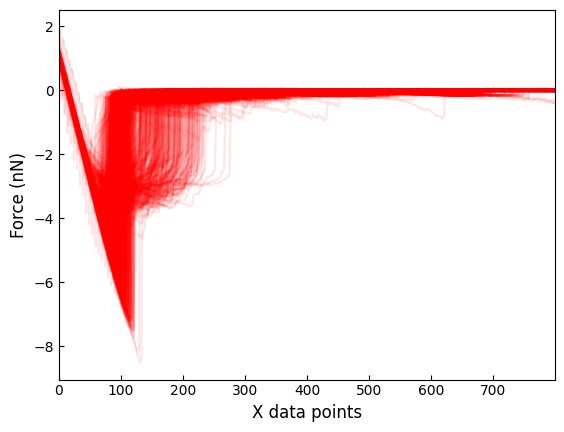

In [7]:
fig,ax = plt.subplots(dpi=100)

for curve in force_data:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

### Split dos dados

Separar as 100 primeiras séries temporais pq talvez o código não tanke com mais que isso.

In [8]:
train_set = force_data[:100]
test_set = force_data[100:]

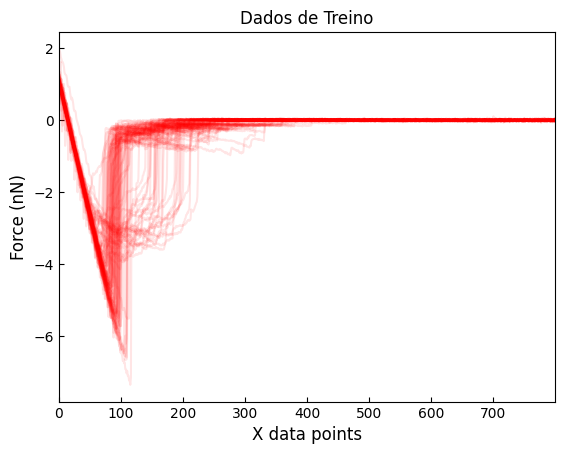

In [9]:
fig,ax = plt.subplots(dpi=100)

for curve in train_set:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

ax.set_title("Dados de Treino")

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

In [10]:
len(train_set[0])

800

In [11]:
# train_set_cort = np.zeros((100,450))

# for i in range(len(train_set_cort)):
#     train_set_cort[i] = train_set[i][:450]

# train_set_cort

In [12]:
# fig,ax = plt.subplots(dpi=100)

# for curve in train_set_cort:
#     ax.plot(curve,c='red',alpha=0.1)

# ax.set_xlabel('X data points',fontsize=12)
# ax.set_ylabel('Force (nN)',fontsize=12)

# ax.tick_params(labelsize=10,direction='in')

# ax.set_xlim([0,train_set_cort.shape[1]-1])

# ax.set_title("Dados de Treino cortados")

# #fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

# plt.show()

### Concatenando os dados
Juntar tudo numa mesma série temporal, como indicado no artigo.

In [13]:
size = len(train_set[0])
sample_size = len(train_set)
print(size, sample_size)

800 100


In [14]:
joined_data = train_set[0]
for i in range(1, sample_size):
    joined_data = np.concatenate((joined_data, train_set[i]))
len(joined_data)

80000

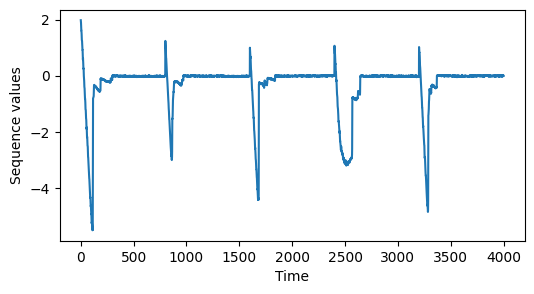

In [15]:
plt.figure(figsize=(6,3))
plt.plot(np.arange(4000), joined_data[:4000])
plt.ylabel("Sequence values")
plt.xlabel("Time")
plt.show()

In [16]:
%%time
mp = matrixProfile.stomp(joined_data, size)

CPU times: user 50.2 s, sys: 6.86 s, total: 57.1 s
Wall time: 57.1 s


In [17]:
print(mp[1])

[23987. 23988. 23989. ... 51997. 51998. 51999.]


Somando uma matriz de zeros à matriz de perfil, assim, os valores de `Nan` se tornam numéricos e iguais a zero.

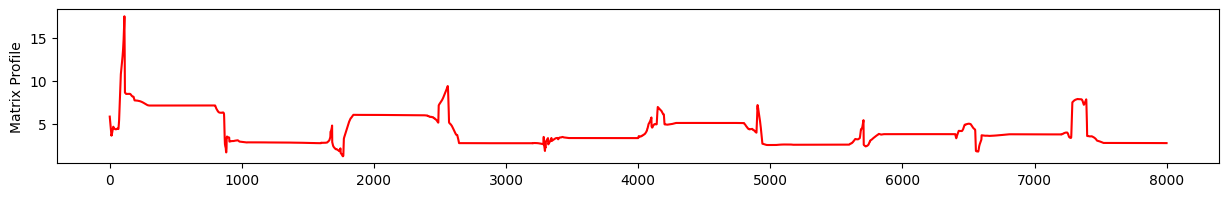

In [18]:
mp_adj = np.append(mp[0],np.zeros(size-1)+np.nan)

plt.figure(figsize=(15,2))
plt.plot(np.arange(8000), mp_adj[:8000], color='red')
plt.ylabel("Matrix Profile")
plt.show()

Extraindo os motifs.

In [19]:
%%time
mtfs, motif_d  = motifs.motifs(joined_data, mp, max_motifs=1000)
len(mtfs)

CPU times: user 173 ms, sys: 104 ms, total: 277 ms
Wall time: 222 ms


38

Criando uma lista com os centros de motifs.

In [20]:
motif_center_list = []
for motif in mtfs:
    center_pointers = list(np.arange(motif[0], motif[0]+size))
    motif_center = joined_data[center_pointers]
    motif_center_list.append(motif_center)

len(joined_data)

80000

In [21]:
len(motif_center_list)

38

### Treinando a rede DTW-SOM

In [22]:
%time
rows = 2
cols = 3
structure = type_conn.grid_four
network = dtwsom.DtwSom(rows, cols, structure)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [23]:
%%time
network.train(motif_center_list, 50)

Epoch 1 achieved an average quantization error of 5.8103
Epoch 2 achieved an average quantization error of 7.0915
Epoch 3 achieved an average quantization error of 6.3317
Epoch 4 achieved an average quantization error of 5.9926
Epoch 5 achieved an average quantization error of 5.9305
Epoch 6 achieved an average quantization error of 5.8574
Epoch 7 achieved an average quantization error of 5.7654
Epoch 8 achieved an average quantization error of 5.5572
Epoch 9 achieved an average quantization error of 5.6714
Epoch 10 achieved an average quantization error of 5.802
Epoch 11 achieved an average quantization error of 5.8846
Epoch 12 achieved an average quantization error of 5.9303
Epoch 13 achieved an average quantization error of 5.9853
Epoch 14 achieved an average quantization error of 5.9657
Epoch 15 achieved an average quantization error of 5.983
Epoch 16 achieved an average quantization error of 5.9811
Epoch 17 achieved an average quantization error of 5.9696
Epoch 18 achieved an aver

50

### Resultados

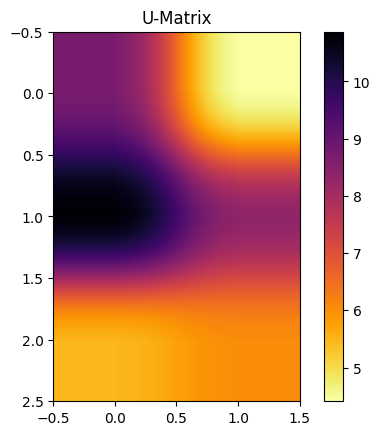

In [30]:
network.show_distance_matrix()

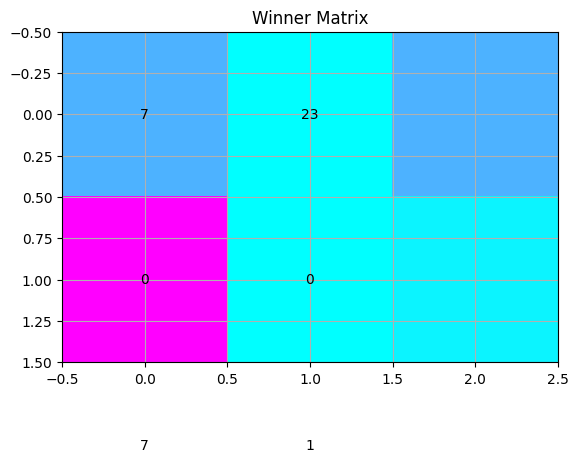

In [31]:
network.show_winner_matrix()

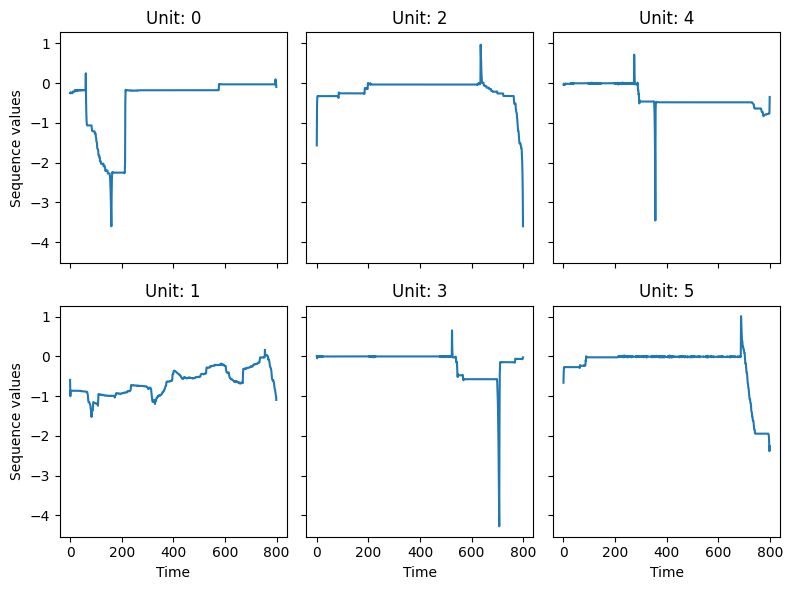

In [32]:
n_neurons = network._size
fig, axs = plt.subplots(2,3,figsize=(8, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/2) # round numbers down to the nearest integer:
    #math.ceil: round a number UP to the nearest integer
    row = neuron_index % 2
    neuron_weights = network._weights[neuron_index]
    axs[row, col].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[row, col].set_title("Unit: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Sequence values")
    if row == 1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

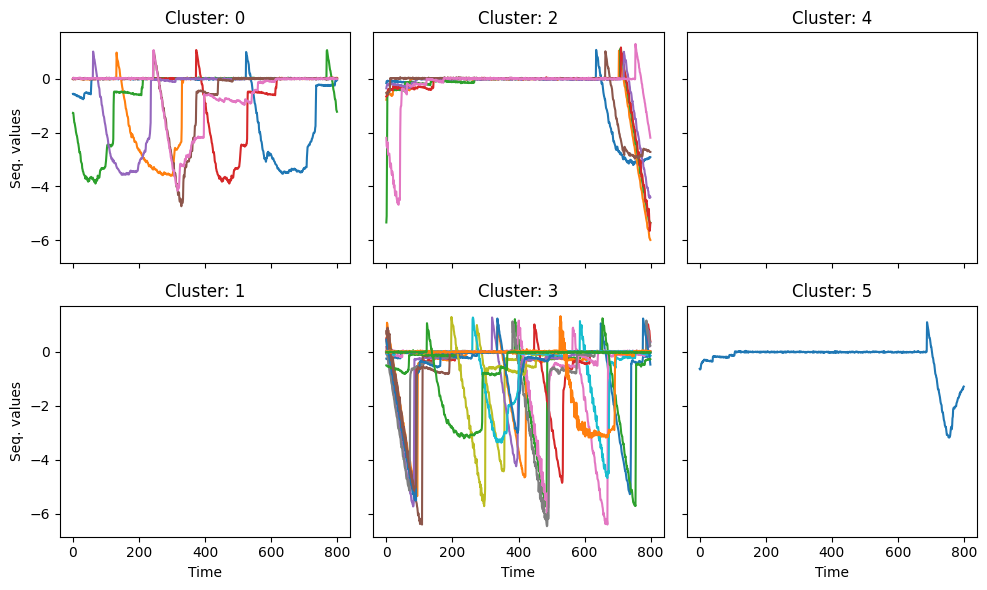

In [33]:
n = rows
n_neurons = network._size
fig, axs = plt.subplots(n,3,figsize=(10, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/n)
    row = neuron_index % n
    cluster_list = network.capture_objects[neuron_index]
    for member_index in cluster_list:
        axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
    axs[row, col].set_title("Cluster: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Seq. values")
    if row == 1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()